<a href="https://colab.research.google.com/github/KillerStrike17/EVA-5/blob/master/5.%20Code%20Drill/EVA5_Code_Drill_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This is Version 3 of the code drill

The main focus here is to get 99.4% accuracy in less than 10k parameters in less than 15 Epochs

## Importing Libraries



In [1]:
import torch 
import torch.nn as nn # All NN Layers
import torch.nn.functional as F # to get loss fucnction
import torch.optim as optim # Optimizer Fucntion
from torchvision import datasets, transforms #Loading Dataset and transform function to perform transformation
from torchsummary import summary # To view summary
%matplotlib inline
import matplotlib.pyplot as plt # To plot graphs
from torch.optim.lr_scheduler import StepLR,OneCycleLR, ReduceLROnPlateau
from tqdm import tqdm


## Data Transformation

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation(fill=(0,),degrees=(-5,5)), # Randomly rotating 50& of the image in the range -5,5
                                       transforms.ToTensor(), # Converting to Tensor
                                       transforms.Normalize((0.1307,),(0.3081,)) # Normalizing the dataset with the mean and std 
                                      ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                    transforms.ToTensor(), # Converting to Tensor
                                    transforms.Normalize((0.1307,),(0.3081,))  # Normalizing the dataset using mean and std
                                  ])

## Dataset Cleaning and Train/Test Split

In [3]:
train = datasets.MNIST('./data',train= True,download= True, transform = train_transforms) # Downloading Train set
test = datasets.MNIST('./data',train= False,download= True, transform = test_transforms) # Downloading Test set

## CONSTANTS

In [4]:
SEED = 1
BATCHSIZE = 128
BATCHSIZE_2 = 64
NUM_OF_WORKER = 4
DROPOUT_VALUE = 0.05
EPOCHS = 15

## Data Loading

In [5]:
# Checking for CUDA
cuda = torch.cuda.is_available()
print("CUDA Available",cuda)

torch.manual_seed(SEED)
if cuda:
  torch.cuda.manual_seed(SEED)

dataloader_args= dict(shuffle = True, batch_size = BATCHSIZE, num_workers = NUM_OF_WORKER,pin_memory = True) if cuda else dict(shuffle = True, batch_size  = BATCHSIZE_2)

train_loader = torch.utils.data.DataLoader(train, **dataloader_args) # creating train data loader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args) # creating test dataloader

CUDA Available True


## The Model

In [6]:
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()

    # Convolution Block 1
    self.convblock1 = nn.Sequential(
        nn.Conv2d(in_channels=1,out_channels=8,kernel_size=(3,3),padding = 0, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(8),
        nn.Dropout(DROPOUT_VALUE)
    )

    # Convolution Block 2
    self.convblock2 = nn.Sequential(
        nn.Conv2d(in_channels=8,out_channels=16,kernel_size=(3,3),padding = 0, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout(DROPOUT_VALUE)
    )

    # Transition Block 1
    self.transitionblock1 = nn.Sequential(
        nn.Conv2d(in_channels = 16,out_channels = 12,kernel_size = (3,3),padding = 0,bias = False),
        nn.MaxPool2d(2,2)
    )

    # Convolution Block 3
    self.convblock3= nn.Sequential(
        nn.Conv2d(in_channels=12,out_channels=16,kernel_size=(3,3),padding = 0, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout(DROPOUT_VALUE)
    )

    # Convolution Block 4
    self.convblock4= nn.Sequential(
        nn.Conv2d(in_channels=16,out_channels=16,kernel_size=(3,3),padding = 0, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout(DROPOUT_VALUE)
    )

    self.convblock5= nn.Sequential(
        nn.Conv2d(in_channels=16,out_channels=16,kernel_size=(3,3),padding = 0, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout(DROPOUT_VALUE)
    )

    self.gap = nn.Sequential(
        nn.AvgPool2d(kernel_size=5),
        nn.Conv2d(in_channels=16,out_channels=10,kernel_size=(1,1),padding = 0, bias = True)
    )
  
  def forward(self, x):
    x = self.convblock1(x)
    x = self.convblock2(x)
    x = self.transitionblock1(x)
    x = self.convblock3(x)
    x = self.convblock4(x)
    x = self.convblock5(x)
    x = self.gap(x)
    x = x.view(-1,10)
    return F.log_softmax(x,dim = -1)



## Model Parameters
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [7]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model,input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 12, 22, 22]           1,728
        MaxPool2d-10           [-1, 12, 11, 11]               0
           Conv2d-11             [-1, 16, 9, 9]           1,728
             ReLU-12             [-1, 16, 9, 9]               0
      BatchNorm2d-13             [-1, 16, 9, 9]              32
          Dropout-14             [-1, 1

In [8]:


train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc.append(100. * correct / len(test_loader.dataset))

In [9]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.09884069114923477 Batch_id=468 Accuracy=90.28: 100%|██████████| 469/469 [00:13<00:00, 33.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0932, Accuracy: 9750/10000 (97.50%)

EPOCH: 1


Loss=0.055611785501241684 Batch_id=468 Accuracy=97.93: 100%|██████████| 469/469 [00:14<00:00, 33.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0495, Accuracy: 9873/10000 (98.73%)

EPOCH: 2


Loss=0.07647103816270828 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:14<00:00, 33.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0426, Accuracy: 9888/10000 (98.88%)

EPOCH: 3


Loss=0.04959070309996605 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:14<00:00, 33.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0310, Accuracy: 9918/10000 (99.18%)

EPOCH: 4


Loss=0.02052976004779339 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:14<00:00, 33.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9922/10000 (99.22%)

EPOCH: 5


Loss=0.007576808333396912 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:14<00:00, 33.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9928/10000 (99.28%)

EPOCH: 6


Loss=0.06502316147089005 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:14<00:00, 33.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9946/10000 (99.46%)

EPOCH: 7


Loss=0.02562093921005726 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:14<00:00, 33.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9949/10000 (99.49%)

EPOCH: 8


Loss=0.013155539520084858 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:14<00:00, 32.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9948/10000 (99.48%)

EPOCH: 9


Loss=0.013766511343419552 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:14<00:00, 32.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9952/10000 (99.52%)

EPOCH: 10


Loss=0.010479533113539219 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:14<00:00, 33.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9953/10000 (99.53%)

EPOCH: 11


Loss=0.011387553997337818 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:14<00:00, 32.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9951/10000 (99.51%)

EPOCH: 12


Loss=0.008642492815852165 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:14<00:00, 32.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9946/10000 (99.46%)

EPOCH: 13


Loss=0.012163106352090836 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:14<00:00, 32.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9951/10000 (99.51%)

EPOCH: 14


Loss=0.006864660885185003 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:14<00:00, 33.21it/s]



Test set: Average loss: 0.0183, Accuracy: 9952/10000 (99.52%)



Text(0.5, 1.0, 'Test Accuracy')

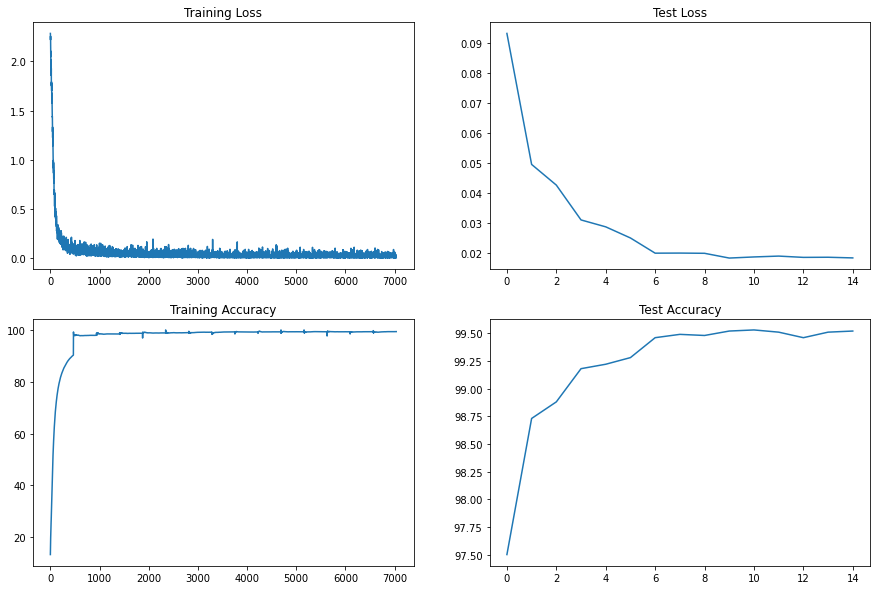

In [10]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [11]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.0660821720957756 Batch_id=468 Accuracy=89.36: 100%|██████████| 469/469 [00:14<00:00, 32.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1112, Accuracy: 9678/10000 (96.78%)

EPOCH: 1


Loss=0.019476594403386116 Batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:14<00:00, 32.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0540, Accuracy: 9839/10000 (98.39%)

EPOCH: 2


Loss=0.04104555770754814 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:14<00:00, 32.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0456, Accuracy: 9858/10000 (98.58%)

EPOCH: 3


Loss=0.08943212777376175 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:14<00:00, 32.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0296, Accuracy: 9905/10000 (99.05%)

EPOCH: 4


Loss=0.06511973589658737 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:14<00:00, 32.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9921/10000 (99.21%)

EPOCH: 5


Loss=0.053805846720933914 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:14<00:00, 32.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9930/10000 (99.30%)

EPOCH: 6


Loss=0.05562053620815277 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:14<00:00, 32.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9919/10000 (99.19%)

EPOCH: 7


Loss=0.029133738949894905 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:14<00:00, 32.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 9919/10000 (99.19%)

EPOCH: 8


Loss=0.022400520741939545 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:14<00:00, 32.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9926/10000 (99.26%)

EPOCH: 9


Loss=0.06987370550632477 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:14<00:00, 32.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9932/10000 (99.32%)

EPOCH: 10


Loss=0.004682046361267567 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:14<00:00, 33.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9941/10000 (99.41%)

EPOCH: 11


Loss=0.007108569610863924 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:13<00:00, 33.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9941/10000 (99.41%)

EPOCH: 12


Loss=0.031052522361278534 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:14<00:00, 33.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9943/10000 (99.43%)

EPOCH: 13


Loss=0.013229970820248127 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:14<00:00, 32.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9942/10000 (99.42%)

EPOCH: 14


Loss=0.013463680632412434 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:14<00:00, 32.36it/s]



Test set: Average loss: 0.0180, Accuracy: 9941/10000 (99.41%)



Text(0.5, 1.0, 'Test Accuracy')

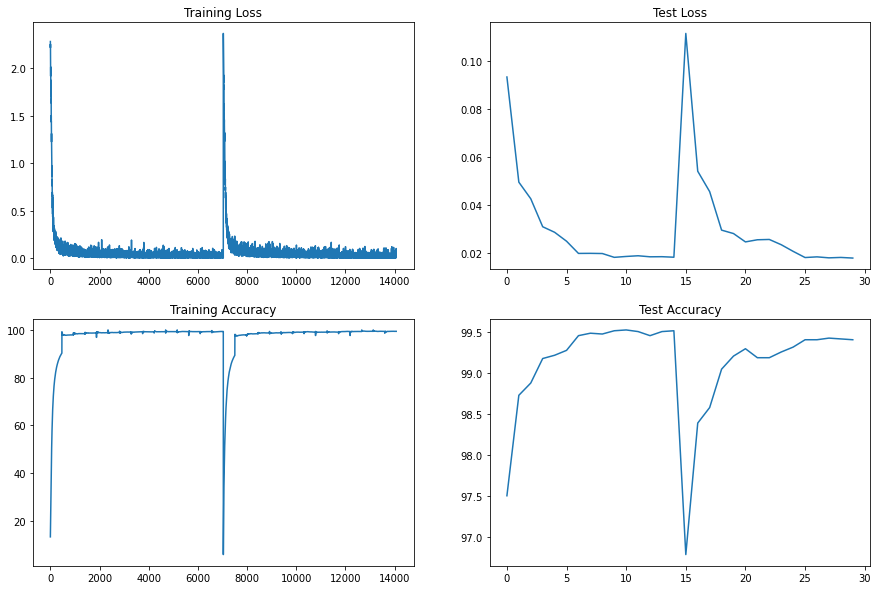

In [12]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")